In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

# Allow importing from parent dir
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import math
import scipy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd

import utils.utils as utils
from classifier.classifier import Classifier
from scipy import stats as st

In [3]:
EXP_NAME = 'GCaMP6_Bisection_Exp6'# TO MODIFY
VIDEO_NAME = "71420_ngcamp_hy6_peduncle48hr" # TO MODIFY
BODY_PART = "/Peduncle/" # TO MODIFY

BISECTION_DATA_HOME = "/Users/katyabrooun/Google Drive/Shared drives/hydra/data-analysis/Bisection_Full/"
SAVE_DIR = '/Users/katyabrooun/Fairhall_Lab/hydra/bisection-data-analysis/exp6' + BODY_PART #TO MODIFY

FILE_FLUO = SAVE_DIR + 'total_fluo_' + VIDEO_NAME + '.csv'
FILE_FLUO_ADJUSTED = SAVE_DIR + 'fluo_adjusted_' + VIDEO_NAME + '.csv'

FILE_LENGTH = SAVE_DIR + "lengths_" + VIDEO_NAME + ".csv"
FILE_LENGTH_ADJUSTED = SAVE_DIR + "lengths_adjusted_" + VIDEO_NAME + ".csv"

FILE_MIDPOINTS = SAVE_DIR + "midpoints_"+ VIDEO_NAME +".csv"
FILE_VIDEO = BISECTION_DATA_HOME + "Original_Videos/" + EXP_NAME + BODY_PART + VIDEO_NAME + ".avi"

FILE_FLUO_PEAKS = SAVE_DIR + "fluo_peaks_" + VIDEO_NAME + ".csv"

SAVE_DIR_CONTRACTION = BISECTION_DATA_HOME + "Contraction_Analysis/"

FILE_CLASSIFIED_PEAKS = SAVE_DIR + "classified_peaks_" + VIDEO_NAME + ".csv"

FPS = 5

In [4]:
def plot_fluo_len(
    ax,
    fluo,
    length,
    x,
    xlabel='',
    label_f="fluo",
    label_l="length",
    alpha_f=1,
    alpha_l=1
):
    
    lns1 = ax.plot(x, length, 'b', label=label_l,alpha=alpha_l)
    lns2 = ax.plot(x, fluo, 'g', label=label_f,alpha=alpha_f)

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')
    ax.set(xlabel=xlabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [5]:
def plot_cluster_sizes_histogram(ax, cluster_sizes, xlim, bar_color, title, ylabel, xlabel):
    y,binEdges = np.histogram(cluster_sizes, bins=5)
    bin_width = binEdges[1]-binEdges[0]
    bincenters = 0.5 * (binEdges[1:]+binEdges[:-1])
    menStd = np.sqrt(y)
    plt.bar(bincenters, y, width=bin_width, edgecolor='black', color=bar_color, yerr=menStd)
    plt.axvline(np.mean(cluster_sizes), color='k', linestyle='dashed', linewidth=1)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim(xlim)
    plt.show()

## Load Fluorescence and Length

In [6]:
# Load fluorescence
fluo = pd.read_csv(FILE_FLUO).values.reshape(-1)

In [7]:
# Load the length
length = pd.read_csv(FILE_LENGTH).values.reshape(-1)

In [8]:
# Set up x axes
min_length = min(len(fluo), len(length))

fluo = fluo[:min_length]
length = length[:min_length]

x_time = np.arange(0, min_length/FPS, 1/FPS)
x_frame = np.arange(0, min_length,1)

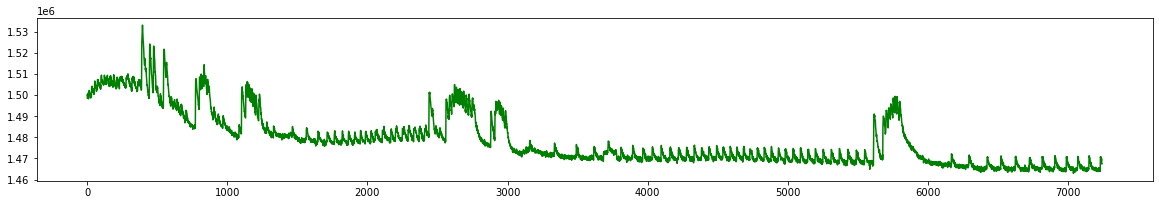

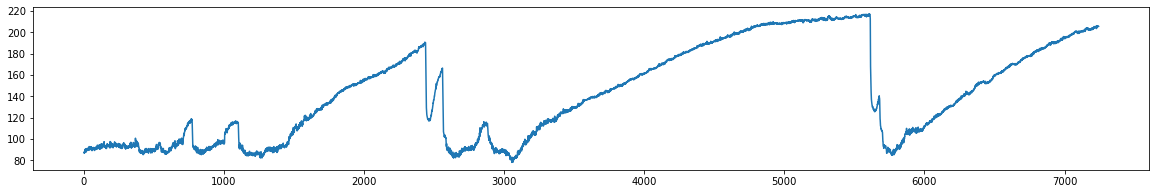

In [9]:
# Plot raw fluo and length
fig1 = plt.figure(figsize=(20,3))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(x_frame,fluo,color='g')
plt.show()

fig2 = plt.figure(figsize=(20,3))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(x_frame,length)
plt.show()

# Data cleaning

## Clean up length time series

### Account for camera shifts

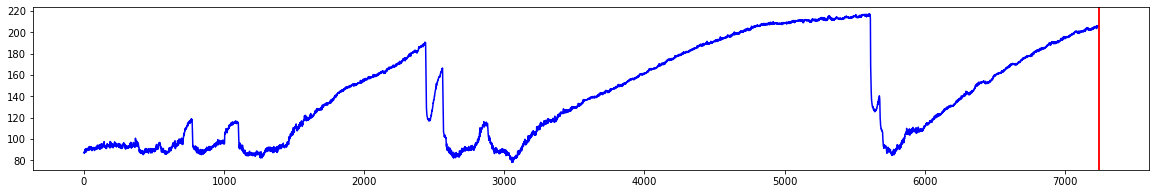

In [10]:
# Fix length spikes caused by rapid frame shifts
start_viz = 0
end_viz = min_length -1

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
ax.plot(x_frame[start_viz:end_viz],length[start_viz:end_viz],color='b')

start_effect = min_length -1
end_effect = min_length -1
ax.axvline(start_effect, color='r')
ax.axvline(end_effect, color='r')

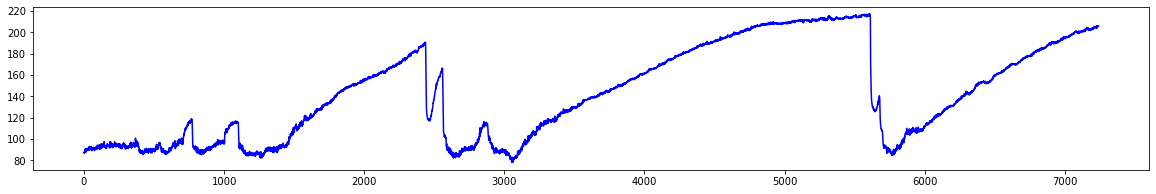

In [11]:
diff = length[end_effect] - length[start_effect - 1]

before = length[:start_effect]
during = []
after = length[end_effect:]-diff

# deal with the small range of frames during which camera is still actively moving

length_start = length[start_effect - 1]
for i in range(start_effect, end_effect):
    diff = length[i] - length_start
    during.append(length[i]-diff)

length_adjusted = list(before) + during + list(after)

plt.figure(figsize=(20,3))
plt.plot(length_adjusted[start_viz:end_viz], 'b')
plt.show()

In [12]:
# Save the results
# df = pd.DataFrame(length_adjusted)
# df.to_csv(FILE_LENGTH_ADJUSTED, index=False)

In [13]:
# length = length_adjusted

## Clean up fluo time series

### Account for camera shifts

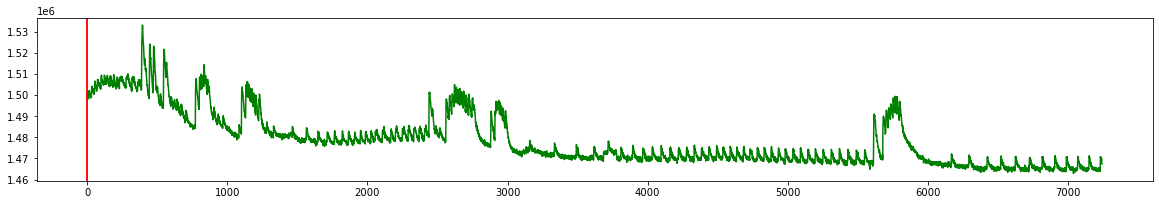

In [14]:
# Identify big gaps between consecutive frames

start_viz = 0
end_viz = min_length

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
ax.plot(x_frame[start_viz:end_viz],fluo[start_viz:end_viz] ,color='g')

start_effect = 0
end_effect = 0
ax.axvline(start_effect, color='r')
ax.axvline(end_effect, color='r')

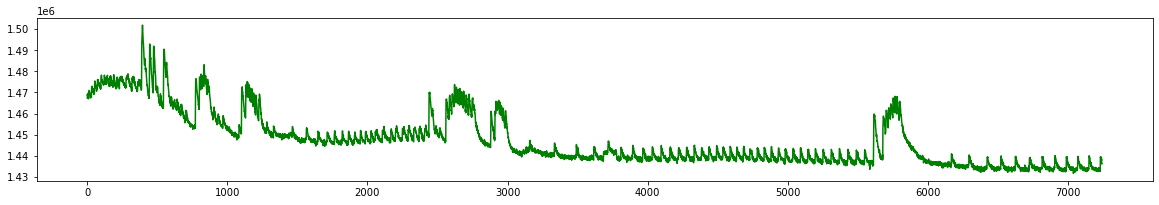

In [15]:
diff = fluo[end_effect] - fluo[start_effect - 1]

before = fluo[:start_effect]
during = []
after = fluo[end_effect:]-diff

# deal with the small range of frames during which camera is still actively moving

fluo_start = fluo[start_effect - 1]
for i in range(start_effect, end_effect):
    diff = fluo[i] - fluo_start
    during.append(fluo[i]-diff)

fluo_adjusted = list(before) + during + list(after)

plt.figure(figsize=(20,3))
plt.plot(fluo_adjusted[start_viz:end_viz], 'g')
plt.show()

In [16]:
# Save the results
# df = pd.DataFrame(fluo_adjusted)
# df.to_csv(FILE_FLUO_ADJUSTED, index=False)

In [17]:
# fluo = fluo_adjusted

### Crop video

In [18]:
# TO MODIFY IF CROPPING VIDEO
start = 0
end = min_length

fluo = fluo[start:end]
length = length[start:end]
x_time = np.arange(start/FPS, end/FPS, 1/FPS)
print(len(x_time))
x_frame = np.arange(start, end, 1)
print(len(x_frame))

7244
7244


### Normalize and smooth

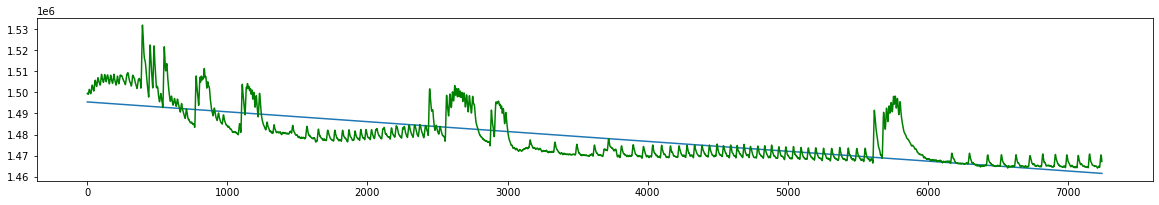

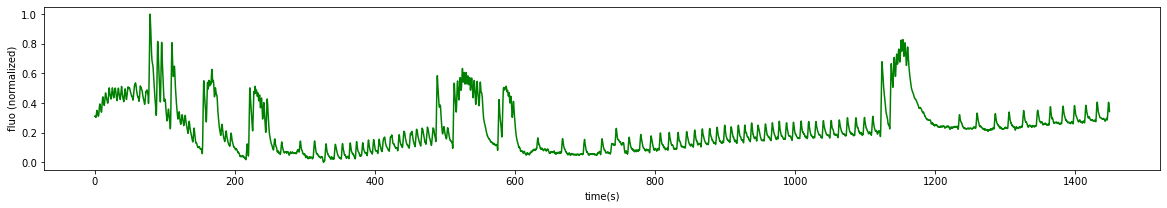

In [19]:
# DO NOT CHANGE KERNEL SIZE FOR SMOOTHING FLUO
smooth_win = 15
fluo = scipy.signal.savgol_filter(fluo, smooth_win, 3)
fluo = utils.remove_trend_fluo(fluo, display=True)

# once we remove trend, fluo no longer reflects absolute a.u. values
fluo = utils.normalize(fluo)

plt.figure(figsize=(20,3))
plt.plot(x_time,fluo,color='g')
plt.xlabel('time(s)')
plt.ylabel('fluo (normalized)')
plt.show()

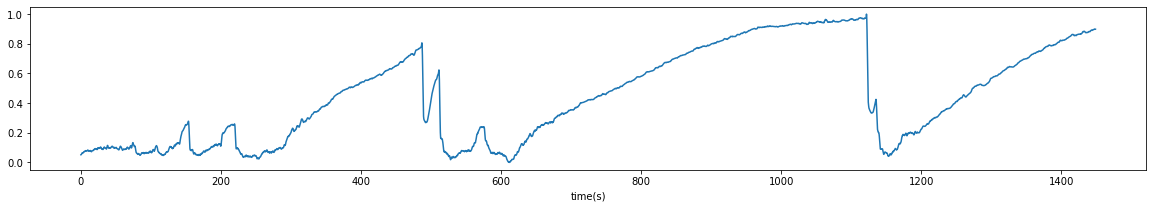

In [20]:
length_smooth = scipy.signal.savgol_filter(length, 15, 3)
length_smooth = utils.normalize(length_smooth)

length = utils.normalize(length)
plt.figure(figsize=(20,3))

plt.plot(x_time,length_smooth)
plt.xlabel('time(s)')
plt.show()

Text(0.5, 1.0, '71420_ngcamp_hy6_peduncle48hr (savgol winlen=15)')

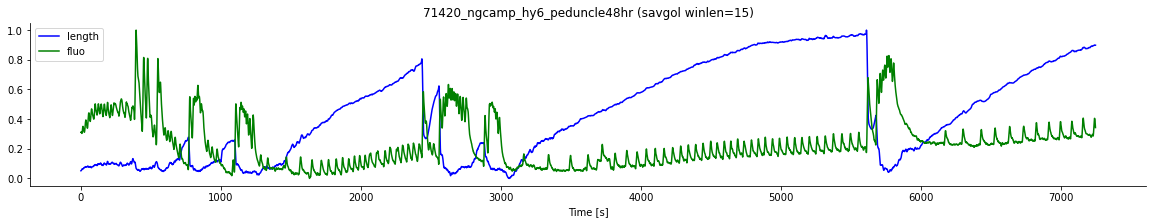

In [21]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)

plot_fluo_len(ax, fluo, length_smooth, x_frame, xlabel="Time [s]",alpha_l=1, alpha_f=1)
ax.set_title(VIDEO_NAME + " (savgol winlen=15)")

### First derivative of fluorescence

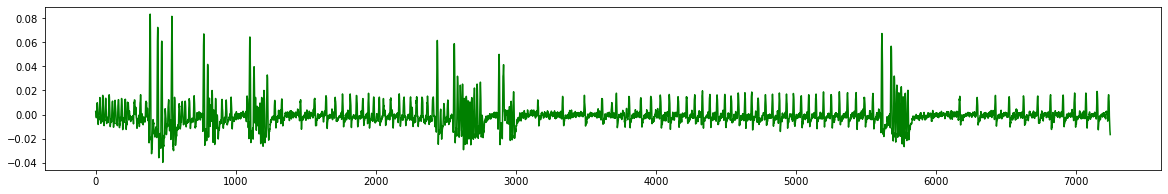

In [22]:
# Plot the change in length, rather than length itself

fluo_grads = np.gradient(fluo)

plt.figure(figsize=(20,3))
plt.plot(fluo_grads, color='g')
plt.show()

### First derviate of fluorescence

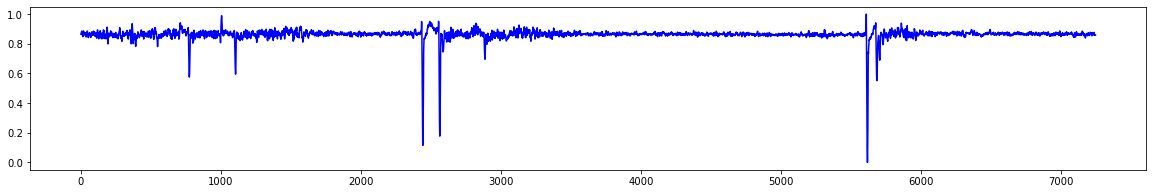

In [23]:
len_grads = np.gradient(length_smooth)

#normalize the gradient
len_grads = utils.normalize(len_grads)

plt.figure(figsize=(20,3))
plt.plot(len_grads, color='b')
plt.show()

## Find peaks in first deriv of fluo

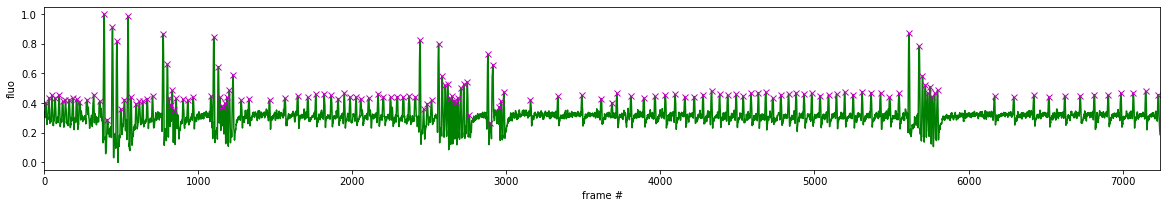

In [24]:
# DO NOT CHANGE THESE PARAMS

# normalize gradient
fluo_grads = utils.normalize(fluo_grads)
prom = 0.1

peaks_index = utils.find_peaks(fluo_grads, height=None, wlen=50, prominence=prom, realign=True, start=0, end=-1)

In [25]:
# Save peaks
df = pd.DataFrame(peaks_index)
df.to_csv(FILE_FLUO_PEAKS, index=False)

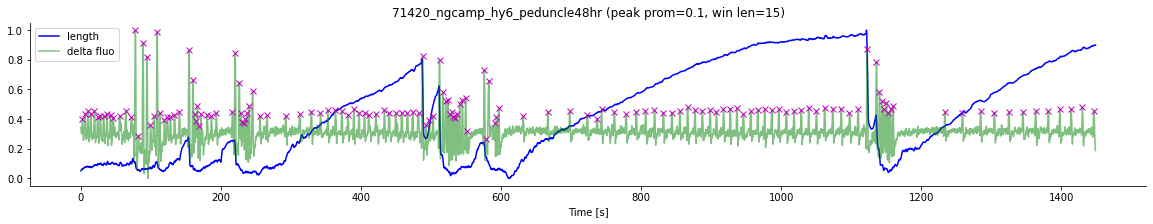

In [26]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
plot_fluo_len(ax, fluo_grads, length_smooth, x_time, xlabel="Time [s]",label_f="delta fluo",alpha_f=0.5)
utils.disp.add_peaks(ax, peaks_index, fluo_grads, fps=5, start=start)
ax.set_title(VIDEO_NAME+ " (peak prom="+str(prom) + ", win len="+str(smooth_win)+")")
plt.show()

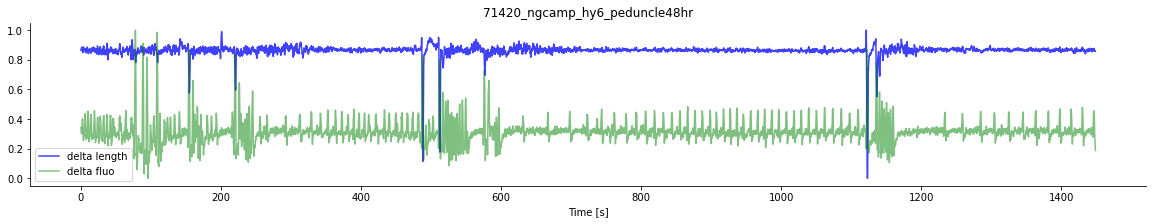

In [27]:
# Visualize grads of fluo and len
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
plot_fluo_len(ax, fluo_grads, len_grads, x_time, xlabel="Time [s]",label_l="delta length", label_f="delta fluo",\
             alpha_l=0.75,alpha_f=0.5)
# utils.disp.add_peaks(ax, peaks_index, fluo_grads, fps=5, start=start)
ax.set_title(VIDEO_NAME)
plt.show()

In [28]:
# ax.axvspan(975, 1150, color='yellow', alpha=0.4)
# fig

## Use Manual Classifier Results

In [29]:
class_peaks = pd.read_csv(FILE_CLASSIFIED_PEAKS).values
print(len(class_peaks))
print(len(peaks_index))

151
151


In [30]:
# Group peaks into CB and RP categories
cb_peaks_index = []
rp_peaks_index = []

# Identify start and end bounds of CB events
cb_bounds = []

# Identify number of spikes per CB and RP event
cb_cluster_sizes = []
rp_cluster_sizes = []

prev = "RP"
period_count = 0

for i in range(len(class_peaks)):
    curr = class_peaks[i]
    if curr == "Neither":
        # Treat this blip like part of same cycle as previous peak
        curr = prev
    elif curr == "CB":
        if prev == "RP":
            cb_bounds.append(peaks_index[i])
            rp_cluster_sizes.append(period_count)
            period_count = 0
        cb_peaks_index.append(peaks_index[i])
        period_count += 1
    elif curr == "RP":
        if prev == "CB":
            cb_bounds.append(peaks_index[i-1])
            cb_cluster_sizes.append(period_count)
            period_count = 0
        rp_peaks_index.append(peaks_index[i])
        period_count += 1
    # End the last period of activity when the series ends
    if i == len(class_peaks) -1:
        if curr == "CB":
            cb_cluster_sizes.append(period_count)
            cb_bounds.append(peaks_index[i])
        elif curr == "RP":
            rp_cluster_sizes.append(period_count)
    prev = curr

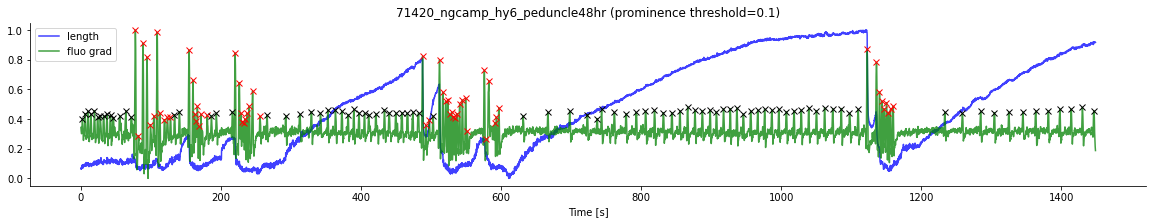

In [31]:
# Plot classified RP and CB peaks
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
plot_fluo_len(ax, fluo_grads, length, x_time, xlabel="Time [s]",label_l="length", label_f="fluo grad",\
             alpha_l=0.75,alpha_f=0.75)
utils.disp.add_peaks(ax, cb_peaks_index, fluo_grads, fps=5, start=start, marker='rx')
utils.disp.add_peaks(ax, rp_peaks_index, fluo_grads, fps=5, start=start, marker='kx')
ax.set_title(VIDEO_NAME + " (prominence threshold="+str(prom)+")")
plt.show()

In [32]:
print(cb_peaks_index)

[389, 410, 443, 472, 496, 521, 544, 563, 596, 618, 639, 772, 800, 812, 822, 831, 843, 856, 902, 1101, 1131, 1141, 1152, 1161, 1173, 1185, 1201, 1225, 1279, 2439, 2463, 2486, 2560, 2583, 2603, 2619, 2632, 2646, 2659, 2671, 2685, 2704, 2723, 2746, 2759, 2880, 2895, 2912, 2954, 2966, 2984, 5613, 5679, 5701, 5720, 5734, 5751, 5765, 5780, 5799]


In [33]:
print(cb_bounds)

[389, 639, 772, 902, 1101, 1279, 2439, 2486, 2560, 2984, 5613, 5799]


In [34]:
# Manually adjust cb bounds
print(cb_bounds)

[389, 639, 772, 902, 1101, 1279, 2439, 2486, 2560, 2984, 5613, 5799]


In [35]:
# Manually adjust cluser sizes of needed
print(cb_cluster_sizes)

[11, 8, 10, 3, 19, 9]


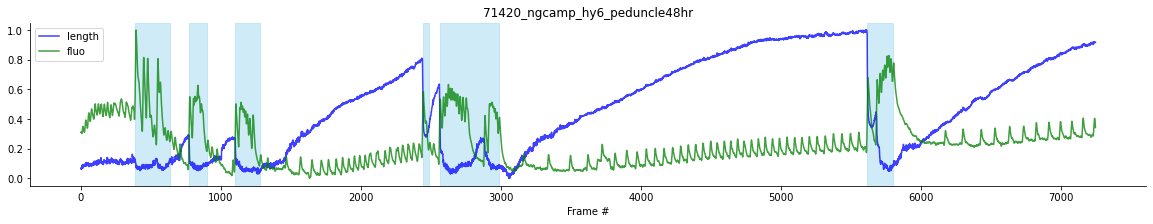

In [36]:
# Plot RP and CB periods

fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
plot_fluo_len(ax, fluo, length, x_frame, xlabel="Frame #",label_l="length", label_f="fluo",\
             alpha_l=0.75,alpha_f=0.75)
for i in range(0,len(cb_bounds)-1,2):
    x1 = cb_bounds[i]
    x2 = cb_bounds[i+1]
    ax.axvspan(x1, x2, color='skyblue', alpha=0.4)

# ax.axvspan(0, cb_bounds[0], color='thistle', alpha=0.4)
# for i in range(1,len(cb_bounds),2):
#     x1 = cb_bounds[i]
#     if i == len(cb_bounds) - 1:
#         x2 = len(fluo)-1
#     else:
#         x2 = cb_bounds[i+1]
#     ax.axvspan(x1, x2, color='thistle', alpha=0.4)
ax.set_title(VIDEO_NAME)
plt.show()

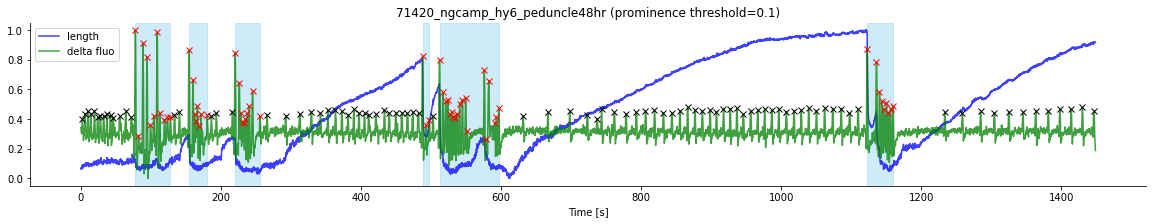

In [37]:
# Everything combined
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
plot_fluo_len(ax, fluo_grads, length, x_time, xlabel="Time [s]",label_l="length", label_f="delta fluo",\
             alpha_l=0.75,alpha_f=0.75)

utils.disp.add_peaks(ax, cb_peaks_index, fluo_grads, fps=5, start=start, marker='rx')
utils.disp.add_peaks(ax, rp_peaks_index, fluo_grads, fps=5, start=start, marker='kx')

for i in range(0,len(cb_bounds),2):
    x1 = cb_bounds[i]
    x2 = cb_bounds[i+1]
    ax.axvspan(x1/FPS, x2/FPS, color='skyblue', alpha=0.4)
    
ax.set_title(VIDEO_NAME + " (prominence threshold="+str(prom)+")")
plt.show()

## Statistical analysis of RP and CB

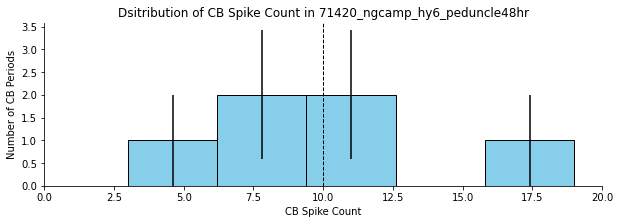

In [38]:
# Histogram for peaks during CBs
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)

xlim = (0,20)

plot_cluster_sizes_histogram(
    ax,
    cb_cluster_sizes,
    xlim,
    bar_color="skyblue",
    title="Dsitribution of CB Spike Count in " + VIDEO_NAME,
    ylabel="Number of CB Periods",
    xlabel="CB Spike Count")

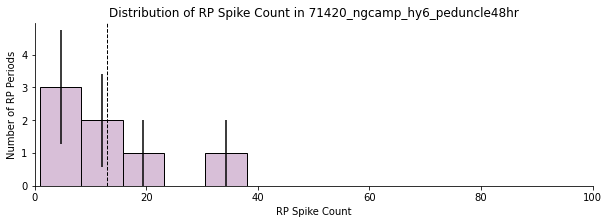

In [39]:
# Histogram for peaks during RPs
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)

xlim = (0,100)

plot_cluster_sizes_histogram(ax,
                             rp_cluster_sizes,
                             xlim,
                             bar_color="thistle",
                             title='Distribution of RP Spike Count in '+ VIDEO_NAME,
                             ylabel="Number of RP Periods",
                             xlabel="RP Spike Count")

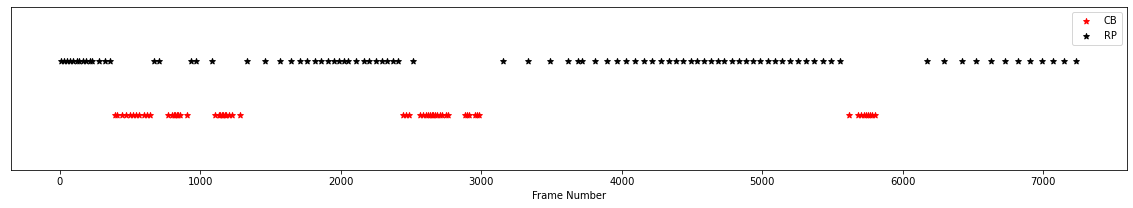

In [40]:
# Visualize CB and RP frequency
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)

y_cb = [0.5] * len(cb_peaks_index)
y_rp = [1] * len(rp_peaks_index)

cb = ax.scatter(cb_peaks_index, y_cb, marker='*',color="red", label="CB")
rp = ax.scatter(rp_peaks_index, y_rp, marker='*',color="black", label="RP")

plt.ylim([0,1.5])
plt.xlabel("Frame Number")
ax.axes.yaxis.set_visible(False)
ax.legend()
plt.show()


## Identify Periods of Contraction with Hengji's Classifier

In [41]:
# Create object
# classifier = Classifier()
classifier.set_midpoints(FILE_MIDPOINTS,
                         winlen_len=51)
classifier.set_videopath(FILE_VIDEO)

NameError: name 'classifier' is not defined

In [ ]:
# Run the classifier

# Parameters:
# winlen_slp: window-length for smoothing slope, larger value == smoother slope curve
# lo_slp_thres: higher bound of slope in predicting contraction, larger value == more sensitive to contraction
# hi_slp_thres: lower bound of slope in predicting elongation, smaller value == more sensitive to elongation
# lo_len_thres: higher bound of length in predicting CB, larger value == looser restriction to predict CB
    # normalized length
# hi_len_thres: lower bound of length in predicting an elongated state, smaller value == looser restriction to predict elongated
# cb_no_elong: whether to deny the "bounding backs" during CB as elongation? True == Yes


classifier.classify_behavior(winlen_slp=51,
                    lo_slp_thres=-0.0001,
                    lo_len_thres=0.1,
                    hi_slp_thres=0.1,
                    hi_len_thres=0.3,
                    cb_no_elong=True,
                    elong_no_cb=True)

In [ ]:
behavior = classifier.behaviors
contraction = np.zeros(classifier.nframes)
elongation = np.zeros(classifier.nframes)

for i in range(classifier.nframes):
    if behavior[i][0] == 'Contraction':
        contraction[i] = 1
    if behavior[i][0] == 'Elongation':
        elongation[i] = 1


In [ ]:
# Plot smoothed and normalized fluo and length
x = np.arange(0,min_length,1)

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)

plot_fluo_len(ax,fluo,length_smooth,x_frame)
plt.subplots_adjust(bottom=0.2)

# save plot (without highlighting)
plt.savefig(SAVE_DIR + VIDEO_NAME + "_smoothed_plot.jpg")
plt.show()

In [ ]:
# Identify periods of contraction and elongation
ax.fill_between(x, contraction, color='orange', alpha=0.3)
ax.fill_between(x, elongation, color='pink', alpha=0.3)
fig

In [ ]:
classifier.cb_bounds = []
classifier.classify_neural_activity(cb_combine=20, min_cb_size=100)
df = pd.DataFrame(classifier.cb_bounds)
df.to_csv(SAVE_DIR_CONTRACTION + VIDEO_NAME + "_cb_bounds.csv", header=["bounds"],index=False)

In [ ]:
# Plot CB events
cb_bounds = pd.read_csv(SAVE_DIR_CONTRACTION + VIDEO_NAME + "_cb_bounds.csv")

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
plot_fluo_len(ax,fluo,length_smooth,x_frame)
plt.subplots_adjust(bottom=0.2)

classifier.plot_cb_periods(ax)
# save plot (with CB highlights)
plt.savefig(SAVE_DIR + VIDEO_NAME + "_with_CB.jpg")

## Find peaks during contraction

In [ ]:
# DO NOT CHANGE THESE PARAMS
peaks_index = utils.find_peaks(fluo, height=None, wlen=50, prominence=0.02, realign=True, start=0, end=-1)

In [ ]:
# Filter out peaks that happen during elongation

# Boolean array representing whether a CB event is occurring during a given frame
cb = np.zeros(classifier.nframes)
it = iter(classifier.cb_bounds)
for x in it:
    for i in range(x,next(it)):
        cb[i] = 1
        
cb_peaks = []

for i in peaks_index:
    if cb[i] == 1:
        cb_peaks.append(i)

cb_peaks = np.array(cb_peaks)

In [ ]:
print(classifier.cb_bounds)

In [ ]:
# Remove peaks that are part of incomplete CB events (cut off either at the beginning or the end of the time series)
start = 0 # EDIT
end = len(cb_peaks) #EDIT
cb_peaks = cb_peaks[start:end]

In [ ]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
utils.disp.add_fluorescence(ax, x_time, fluo, "Time [s]", "Fluo (normalized)")
utils.disp.add_peaks(ax, cb_peaks, fluo, fps=5)
plt.show()

In [ ]:
# Organize peaks into CB events

boolean_peaks = np.zeros(len(cb))
for i in cb_peaks:
    boolean_peaks[i] = 1

cluster_ids = []
cluster_num = -1
prev_cb = False
for i in range(len(cb)):
    if boolean_peaks[i] == 1 and prev_cb:
        cluster_ids.append(cluster_num)
    elif boolean_peaks[i] == 1 and not prev_cb:
        cluster_num += 1
        cluster_ids.append(cluster_num)
        prev_cb = True
    elif cb[i] == 0:
        prev_cb = False

cluster_ids = np.array(cluster_ids)

In [ ]:
clustered_peaks = np.vstack((cb_peaks, cluster_ids)).T

df = pd.DataFrame(clustered_peaks, columns=("Frame", "Cluster Id"))

In [ ]:
df.to_csv(SAVE_DIR_CONTRACTION + VIDEO_NAME + "_cb_spikes.csv")

## Stats for spikes within CB events

In [ ]:
spikes = pd.read_csv(SAVE_DIR_CONTRACTION + VIDEO_NAME + "_cb_spikes.csv")

In [ ]:
cluster_sizes = spikes.groupby(by="Cluster Id").count()["Frame"]

In [ ]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)

y,binEdges = np.histogram(cluster_sizes, bins=5)
bin_width = binEdges[1]-binEdges[0]
bincenters = 0.5 * (binEdges[1:]+binEdges[:-1])
menStd = np.sqrt(y)
plt.bar(bincenters, y, width=bin_width, edgecolor='black', color='b', yerr=menStd)
plt.axvline(np.mean(cluster_sizes), color='k', linestyle='dashed', linewidth=1)
ax.set(title='Distribution of spike count during contraction bursts', xlabel="Spike count", ylabel="Number of CB events")
plt.show()

In [ ]:
# Create 95% confidence interval for mean number of spikes per cluster. Using t distribution because n < 30
st.t.interval(alpha=0.95, df=len(cluster_sizes)-1, loc=np.mean(cluster_sizes), scale=st.sem(cluster_sizes))